In [1]:
import sys
sys.path.extend(["../", "../src"])

In [2]:
from timeit import timeit

from tqdm import tqdm
from memory_profiler import memory_usage
import numpy as np
from scipy.stats import poisson

import matplotlib
import matplotlib.pyplot as plt
import torch as th
from torch.utils.data import TensorDataset


from src.loss import phase_insensitive_loss_cvx
from src.gd_opt import learn_phase_insensitive_povm
from src.quantum import pnr_povm, diag_povm_fidelity
from src.utils import check_diag_povm, find_lambda_max
from src.custom_types import Hyperparameters

matplotlib.rcParams.update({"font.size": 16})
plt.rcParams["figure.dpi"] = 125 #200  # set fig resolution
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})

seed = 42  # for reproducibility
th.manual_seed(seed);

### Time complexity

In [ ]:
Ms = range(100, 375, 25)
device = 'cpu'
N = 25
D = 2000
eta = 1.
lam_smoothing = 0e-5
number = 5
time_gd = []
time_mosek = []
avg_fids_mosek = []
iters_mosek = []
hyperparams = Hyperparameters(lr=0.01, lr_decay=0.999, beta1=0.9, beta2=0.9, num_epochs=100, batch_size=25)

In [ ]:
for M in tqdm(Ms, desc="Performing time experiments"):
    # PNR detector POVM
    true_povm = pnr_povm(hilbert_dim=M, N=N, eta=eta)
    true_povm = th.vstack( [th.diagonal(E) for E in true_povm] ).T

    max_avg = find_lambda_max(M, eps=1e-5)  # get max avg photon number for probes
    n_bars = np.linspace(0, max_avg, D)
    probes = th.tensor(np.array([ poisson.pmf(k=list(range(M)), mu=n_bar) for n_bar in n_bars ]), dtype=th.float32) 

    targets = probes @ true_povm  

    M, N, = probes.shape[1], targets.shape[1]
    logits = th.rand((M, N)) - 1
    logits = logits.to(device)
    logits.requires_grad = True

    probes = probes.to(device, dtype=th.float32)
    targets = targets.to(device)
    dataset = TensorDataset(probes, targets)
    
    logits, losses, _, _ = learn_phase_insensitive_povm(logits, hyperparams, dataset, lam_smoothing, False)
    # plt.plot(losses, label=rf"$M$={M}")
    # plt.xlabel("Iterations")
    # plt.ylabel("Loss")
    # plt.yscale("log")
    # plt.legend()
    # plt.show();

    Pi = th.softmax(logits, dim=1).to('cpu')  # rows are probability vectors so apply softmax along them
    
    if check_diag_povm(Pi.T, tol=1e-5) is not True:
        print(f"WARNING: Gradient descent got invalid solution POVM for M={M}")

    Fs = [ diag_povm_fidelity(th.diag(Pi[:, i]), true_povm[:, i]) for i in range(true_povm.shape[1]) ]

    Pi, prob, iters = phase_insensitive_loss_cvx(targets.cpu().numpy(), probes.cpu().numpy(), lam_smoothing, "MOSEK")
    Pi = th.tensor(Pi)

    if check_diag_povm(Pi.T, tol=1e-5) is not True:
        print(f"WARNING: CVXPY got invalid solution POVM for M={M}")

    iters_mosek.append(iters)
    Fs = [ diag_povm_fidelity(Pi[:, i], true_povm[:, i]) for i in range(true_povm.shape[1]) ]
    avg_fids_mosek.append(sum(Fs)/len(Fs))

    # compute times
    t = timeit(lambda: learn_phase_insensitive_povm(logits, hyperparams, dataset, lam_smoothing, False), number=number)
    time_gd.append(t / number) 

    t = timeit(lambda: phase_insensitive_loss_cvx(targets.cpu().numpy(), probes.cpu().numpy(), lam_smoothing, "MOSEK"), number=number) 
    time_mosek.append(t / number)

Performing time experiments: 100%|██████████| 11/11 [45:58<00:00, 250.75s/it]


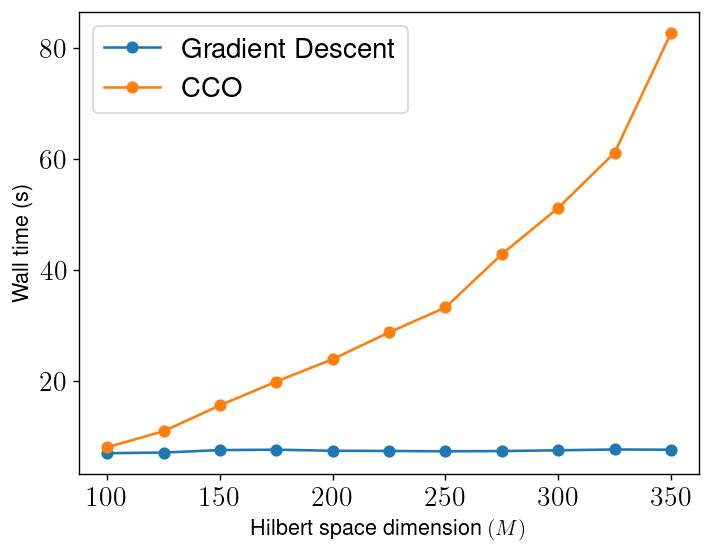

In [5]:
plt.plot(Ms, time_gd, label="Gradient Descent", marker="o")
plt.plot(Ms, time_mosek, label="CCO", marker="o")
plt.xlabel(r"Hilbert space dimension $(M)$", fontsize=12.5)
plt.ylabel("Wall time (s)", fontsize=12.5)
# plt.yscale("log")
plt.legend();

if eta < 1.0:
    plt.savefig("figs/lossy_wall_clock.png", dpi=300)
else:
    plt.savefig("figs/ideal_wall_clock.png", dpi=300)

In [6]:
time_per_iter_gd = [ t/hyperparams.num_epochs for t in time_gd ]

time_per_iter_mosek = [ t/iters for t, iters in zip(time_mosek, iters_mosek) ]

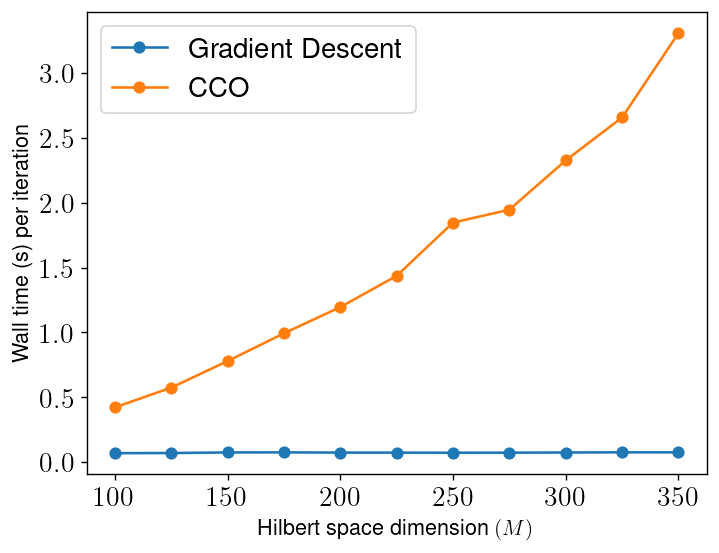

In [7]:
plt.plot(Ms, time_per_iter_gd, label="Gradient Descent", marker="o")
plt.plot(Ms, time_per_iter_mosek, label="CCO", marker="o")
plt.xlabel(r"Hilbert space dimension $(M)$", fontsize=12.5)
plt.ylabel("Wall time (s) per iteration", fontsize=12.5)
# plt.yscale("log")
plt.legend();
if eta < 1.0:
    plt.savefig("figs/lossy_wall_iter.png", dpi=300)
else:
    plt.savefig("figs/ideal_wall_iter.png", dpi=300)

In [ ]:
gd_trials = 20
avg_fids_gd_sample = []

for M in tqdm(Ms, desc="Performing time experiments"):
    avg_fids_gd_M = []
    # PNR detector POVM
    true_povm = pnr_povm(hilbert_dim=M, N=N, eta=eta)
    true_povm = th.vstack( [th.diagonal(E) for E in true_povm] ).T

    max_avg = find_lambda_max(M, eps=1e-5)  # get max avg photon number for probes
    n_bars = np.linspace(0, max_avg, D)
    probes = th.tensor(np.array([ poisson.pmf(k=list(range(M)), mu=n_bar) for n_bar in n_bars ]), dtype=th.float32) 

    targets = probes @ true_povm  
    
    M, N, = probes.shape[1], targets.shape[1]
    
    probes = probes.to(device, dtype=th.float32)
    targets = targets.to(device)
    dataset = TensorDataset(probes, targets)

    for i in range(gd_trials):
        
        logits = th.rand((M, N)) - 1
        logits = logits.to(device)
        logits.requires_grad = True    
        
        logits, losses, _, _ = learn_phase_insensitive_povm(logits, hyperparams, dataset, lam_smoothing, False)

        Pi = th.softmax(logits, dim=1).to('cpu')  # rows are probability vectors so apply softmax along them
        
        if check_diag_povm(Pi.T, tol=1e-5) is not True:
            print(f"WARNING: Gradient descent got invalid solution POVM for M={M}")

        Fs = [ diag_povm_fidelity(th.diag(Pi[:, i]), true_povm[:, i]) for i in range(true_povm.shape[1]) ]
        avg_fids_gd_M.append(sum(Fs)/len(Fs))
    
    avg_fids_gd_sample.append(avg_fids_gd_M)

Performing time experiments:  91%|█████████ | 10/11 [17:36<01:45, 105.67s/it]


KeyboardInterrupt: 

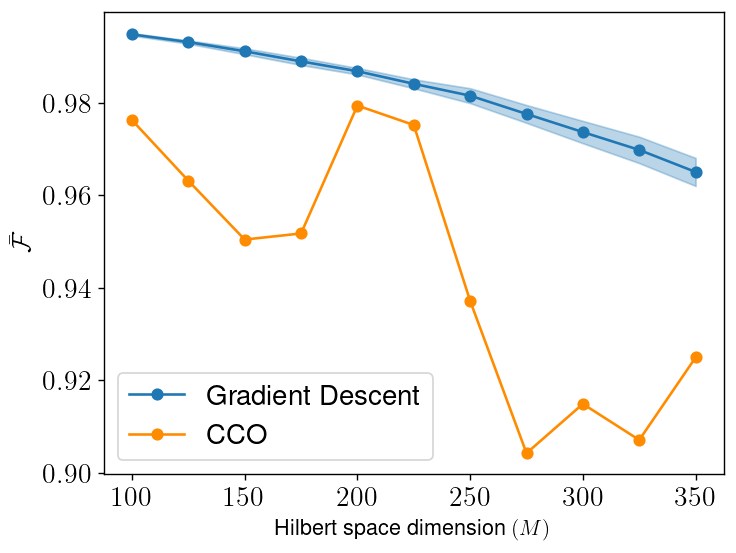

In [ ]:
arr = np.array(avg_fids_gd_sample)
mean = arr.mean(axis=1)
lower = mean - np.std(arr, axis=1)
upper = mean + np.std(arr, axis=1)

plt.plot(Ms, mean, color='C0', label='Gradient Descent', marker="o")
plt.fill_between(Ms, lower, upper, color='C0', alpha=0.3)
plt.plot(Ms, avg_fids_mosek, label="CCO", marker="o", color="darkorange")
plt.xlabel(r"Hilbert space dimension $(M)$", fontsize=12.5)
plt.ylabel(r"$\bar{\mathcal{F}}$", fontsize=15.0)
# plt.yscale("log")
plt.legend();
if eta < 1.0:
    plt.savefig("figs/lossy_fidelity.png", dpi=300)
else:
    plt.savefig("figs/ideal_fidelity.png", dpi=300)

### Memory complexity

In [ ]:
# Ms = range(50, 200, 50)
# device = 'cuda'
# mem_usage_gd = []
# mem_usage_mosek = []
# mem_usage_scs = []

# for M in Ms:
#     # PNR detector POVM
#     eta = random.uniform(0.1, 0.9)
#     true_povm = pnr_povm(hilbert_dim=M, N=N, eta=0.9)
#     true_povm = th.vstack( [th.diagonal(E) for E in true_povm] ).T

#     max_avg = M/1.75
#     n_bars = np.linspace(0, max_avg, D)
#     probes = th.tensor(np.array([ poisson.pmf(k=list(range(M)), mu=n_bar) for n_bar in n_bars ])) 

#     targets = probes @ true_povm  
#     lam_smoothing = 1e-5
#     hyperparams = Hyperparameters(lr=0.1, lr_decay=0.999, beta1=0.9, beta2=0.9, num_epochs=50, batch_size=32)

#     M, N, = probes.shape[1], targets.shape[1]
#     logits = th.rand((M, N)) - 1
#     logits = logits.to(device)
#     logits.requires_grad = True

#     probes = probes.to(device)
#     targets = targets.to(device)
#     dataset = TensorDataset(probes, targets)
    
#     mem = memory_usage( (learn_phase_insensitive_povm, (logits, hyperparams, dataset, lam_smoothing)) )
#     mem_usage_gd.append(max(mem) / 1000)  # divide by 1k to go from Mb to Gb

#     mem = memory_usage( (phase_insensitive_loss_cvx, (targets.cpu().numpy(), probes.cpu().numpy(), lam_smoothing, "MOSEK")) ) 
#     mem_usage_mosek.append(max(mem) / 1000)


In [ ]:
# plt.plot(Ms, mem_usage_gd, label="Gradient Descent", marker="o")
# plt.plot(Ms, mem_usage_mosek, label="CVXPY - MOSEK", marker="o")
# plt.xlabel(r"Hilbert space truncation $M$ ")
# plt.ylabel("Maximum memory usage (Gb)")
# # plt.yscale("log")
# plt.legend();